<a href="https://colab.research.google.com/github/LoniQin/deep_learning_notebooks/blob/master/tensorflow/MnistVariationalAutoEncoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Packages

In [32]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Flatten, Conv2D, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler

from tensorflow.keras.datasets import mnist

## Mounting Google Drive
For convenience we mount a Google Drive so that we can read and write a from it and sync data to local computer.

In [2]:
drive_path = "/content/drive"
data_path = drive_path + "/MyDrive/data"


In [4]:
from google.colab import drive
drive.mount(drive_path)

Mounted at /content/drive


## Creating run folders

In [33]:
run_folder = os.path.join(data_path, "mnist_variational_auto_encoder") 
images_path = os.path.join(run_folder, "images")
if not os.path.exists(run_folder):
  os.mkdir(run_folder)
  os.mkdir(images_path)

## Loading the data

Now load the mnist data.

In [34]:
(train_x, train_y), _ = mnist.load_data()

In [35]:
print(train_x.shape)
print(train_y.shape)

(60000, 28, 28)
(60000,)


Filter some number to generate realistic images.

In [36]:
num = 9
filtered_images = []
filtered_numbers = []
for i in range(train_y.shape[0]):
  if train_y[i] == num:
    filtered_images.append(train_x[i, :, :])
    filtered_numbers.append(train_y[i])
filtered_images = np.array(filtered_images)
filtered_images = filtered_images.reshape((filtered_images.shape[0], filtered_images.shape[1], filtered_images.shape[2], 1))
filtered_numbers = np.array(filtered_numbers)
print(filtered_images.shape)
print(filtered_numbers.shape)

(5949, 28, 28, 1)
(5949,)


Now plot some random images:

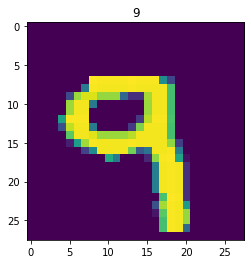

In [37]:
i = np.random.randint(0, filtered_numbers.shape[0])
plt.title(filtered_numbers[i])
plt.imshow(filtered_images[i, :, :, :].reshape(filtered_images.shape[1], filtered_images.shape[2]))

In [38]:
filtered_images = filtered_images / 255.0

## Building the Variational AutoEncoder

Define common parameters.

In [39]:
input_shape = filtered_images.shape[1:]
z_dim = 2

Now build the Encoder.

In [40]:
encoder_parameters = [(32, 3, 1), (64, 3, 2),  (64, 3, 2), (64, 3, 1)]
encoder_input = Input(shape=input_shape, name='encoder_input')
x = encoder_input
for i in range(len(encoder_parameters)):
  item = encoder_parameters[i]
  conv_layer = Conv2D(filters=item[0], kernel_size=item[1], strides=item[2], padding='same', name='encoder_conv_%d'%(i))
  x = conv_layer(x)
  x = LeakyReLU()(x)
  x = BatchNormalization()(x)
  x = Dropout(0.25)(x)
shape_before_flattening = K.int_shape(x)[1:]
x = Flatten()(x)
mu = Dense(z_dim, name='mu')(x)
log_var = Dense(z_dim, name='log_var')(x)
encoder_mu_log_var = Model(encoder_input, (mu, log_var))
def sampling(args):
  mu, log_var = args
  epsilon = K.random_normal(shape=K.shape(mu), mean=0, stddev=1.)
  return mu + K.exp(log_var / 2) * epsilon

encoder_output = Lambda(sampling, name='encoder_output')([mu, log_var])
encoder = Model(encoder_input, encoder_output)


In [41]:
encoder.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 28, 28, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 28, 28, 32)   128         leaky_re_lu_7[0][0]              
____________________________________________________________________________________________

Now build the Decoder. For convenience and elegance, make the Encoder mirror of the Encoder.

In [42]:
decoder_parameters = [(64, 3, 1), (64, 3, 2),  (32, 3, 2), (1, 3, 1)]

In [43]:
decoder_input = Input(shape=(z_dim, ), name='decoder_input')
x = Dense(np.prod(shape_before_flattening))(decoder_input)
x = Reshape(shape_before_flattening)(x)
for i in range(len(decoder_parameters)):
  item = decoder_parameters[i]
  conv_t_layer = Conv2DTranspose(filters=item[0], kernel_size=item[1], strides=item[2], padding='same', name='decoder_conv_t_%d'%(i))
  x = conv_t_layer(x)
  if i < len(decoder_parameters) - 1:
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
  else:
    x = Activation('sigmoid')(x)
decoder_output = x
decoder = Model(decoder_input, decoder_output)

In [44]:
decoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3136)              9408      
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
decoder_conv_t_0 (Conv2DTran (None, 7, 7, 64)          36928     
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 7, 7, 64)          0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 7, 7, 64)          256       
_________________________________________________________________
dropout_11 (Dropout)         (None, 7, 7, 64)          0   

Now join the Encoder to the Decoder so that we can train the encoder and decoder simutaneously.

In [45]:
model_input = encoder_input
model_output = decoder(encoder_output)
model = Model(model_input, model_output)

This is the overall archetecture of AutoEncoder.

In [46]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 28, 28, 32)   320         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_7 (LeakyReLU)       (None, 28, 28, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 28, 28, 32)   128         leaky_re_lu_7[0][0]              
____________________________________________________________________________________________

## Defining Callbacks
Define a ModelCheckpoint to save weights for further usage.

In [21]:
checkpoint = ModelCheckpoint(os.path.join(run_folder, 'weights.h5'), save_weights_only = True, verbose=1)

Define a Learning Rate Scheduler to fine tune learning rate over time.

In [22]:
def scheduler(epoch, lr):
  if epoch < 5:
    return lr
  else:
    return lr * 0.5
schedular = LearningRateScheduler(scheduler)

Define a costom Callback to save latest images.

## Compiling the model

In [23]:
batch_size = 64
learning_rate = 0.001
epochs = 1

In [47]:
r_loss_factor = 1000
optimizer = Adam(learning_rate)
def vae_r_loss(y_true, y_pred):
  r_loss = K.mean(K.square(y_true - y_pred), axis=[1, 2, 3])
  return r_loss_factor * r_loss
def vae_kl_loss(y_true, y_pred):
  kl_loss = -0.5 * K.sum(1 + log_var - K.square(mu) - K.exp(log_var), axis = 1)
  return kl_loss
def vae_loss(y_true, y_pred):
  r_loss = vae_r_loss(y_true, y_pred)
  kl_loss = vae_kl_loss(y_true, y_pred)
  return r_loss + kl_loss
model.compile(optimizer=optimizer, loss=vae_loss, metrics=[vae_r_loss, vae_kl_loss])

## Loading weights if needed

In [48]:
weights_path = os.path.join(run_folder, "weights.h5")
if os.path.exists(weights_path):
  model.load_weights(weights_path)

## Training the model

In [49]:
model.fit(x=filtered_images, y=filtered_images, batch_size=batch_size, epochs=10, shuffle=True, callbacks=[checkpoint, schedular])

Train on 5949 samples
Epoch 1/10
5949/5949 [==============================] - ETA: 0s - loss: 101.7085 - vae_r_loss: 94.6288 - vae_kl_loss: 7.0797
Epoch 00001: saving model to /content/drive/MyDrive/data/mnist_variational_auto_encoder/weights.h5
5949/5949 [==============================] - 29s 5ms/sample - loss: 101.7085 - vae_r_loss: 94.6288 - vae_kl_loss: 7.0797
Epoch 2/10
5949/5949 [==============================] - ETA: 0s - loss: 62.2846 - vae_r_loss: 57.1770 - vae_kl_loss: 5.1076
Epoch 00002: saving model to /content/drive/MyDrive/data/mnist_variational_auto_encoder/weights.h5
5949/5949 [==============================] - 28s 5ms/sample - loss: 62.2846 - vae_r_loss: 57.1770 - vae_kl_loss: 5.1076
Epoch 3/10
5949/5949 [==============================] - ETA: 0s - loss: 55.3273 - vae_r_loss: 50.5534 - vae_kl_loss: 4.7738
Epoch 00003: saving model to /content/drive/MyDrive/data/mnist_variational_auto_encoder/weights.h5
5949/5949 [==============================] - 28s 5ms/sample - loss:

## Generate random images

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2325: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


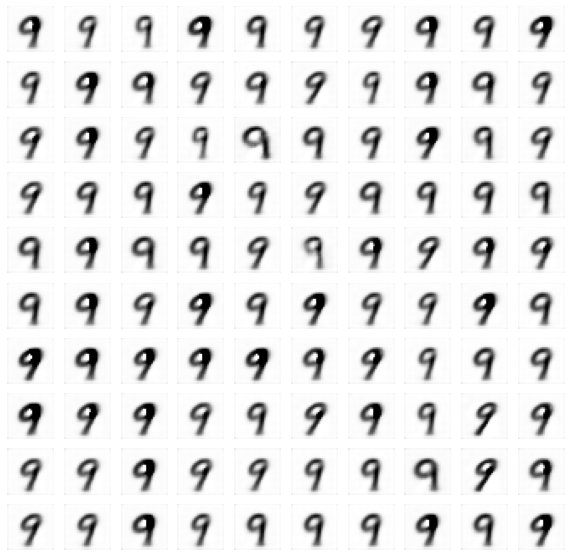

In [50]:
row_count, column_count = 10, 10
noise = np.random.normal(size = (row_count * column_count,z_dim))
gen_imgs = decoder.predict(noise) * 255.0
fig, axs = plt.subplots(row_count, column_count, figsize=(10,10))
for i in range(row_count):
    for j in range(column_count):
        axs[i,j].imshow(np.squeeze(gen_imgs[i * row_count + j, :,:,:]), cmap = 'gray_r')
        axs[i,j].axis('off')
plt.show()